# LAB5

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import math
import os

In [2]:
class PGMImage:
    def __init__(self, file_path=None):
        self.magic_number = None
        self.width = 0
        self.height = 0
        self.maxval = 0
        self.pixels = []
        self.pixels_2d = [[]]

        if file_path:
            self.mypgmread(file_path)
            self.pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))


    def mypgmread(self, file_path):
        with open(file_path, 'rb') as file:
            self.magic_number = file.readline().strip().decode('ascii')

            line = file.readline().strip()
            while line.startswith(b'#'): 
                line = file.readline().strip()

            self.width, self.height = map(int, line.split())
            self.maxval = int(file.readline().strip())
            data = file.read()
            self.pixels = list(data)

    def modify_pixels(self, row_start, row_end, new_value):
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        pixels_2d[row_start:row_end, :] = new_value
        self.pixels = pixels_2d.flatten().tolist()

    def mypgmwrite(self, filename):
        pixel_array = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))

        with open(filename, 'wb') as file:
            file.write(f"{self.magic_number}\n".encode())
            file.write(f"{self.width} {self.height}\n".encode())
            file.write(f"{self.maxval}\n".encode())
            pixel_array.tofile(file)



####################################################################################################################################################
############################## LAB-03 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    # 2D Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Dfft(self, image= None, point_m = None, point_n = None):
        if image is None:
            image = self.pixels_2d  # Varsayılan olarak sınıfın görüntüsünü kullanır
        
        # Giriş görüntüsünün boyutlarını al
        height, width = image.shape
        if point_m == None:
            point_m = height
        if point_n == None:
            point_n = width
        # Fourier Dönüşümü sonucunu tutacak karmaşık (complex) dizi oluştur
        fourier_array = np.zeros(shape = (point_m, point_n), dtype=complex)
        # Satır bazında 1D FFT uygulanır
        for i in range(height):
            fourier_array[i] = np.fft.fft(image[i], n = point_n)
        
        # Sütun bazında 1D FFT uygulanır
        for k in range(point_n):
            fourier_array[:, k] = np.fft.fft(fourier_array[:, k], n = point_m)
        
        return fourier_array

# Ortalanmış Fourier dönüşüm maskesi uygulayan fonksiyon
    def centered_fourier(self):
        centered_mask = np.zeros((self.height, self.width), dtype=complex)
        for x in range(0 , self.height):
            for y in range(0 , self.width):
                centered_mask[x][y] = (-1)**(x + y)

        return centered_mask * self.pixels_2d


# 2D Ters Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Difft(self, image = None, point_m = None, point_n = None):
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass    
        
        conj_input = np.conj(image)     # Giriş görüntüsünün konjugesini al
        conj_output = self.my2Dfft(conj_input, point_m, point_n) # konjugesi alınmış görüntünün fourier transformunu al
        inverse_conj_output = conj_output / (self.height * self.width) # Çıktıyı satır*sütun değerine böl
        inverse_image = np.conj(inverse_conj_output) # çıkış değerinin de konjugesi alınır ve original image elde edilir.

        return inverse_image


    def myImageCorrelation(self, kernel, image = None): # kernel dışarıdan verilir
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass   
        k_height, k_width = kernel.shape # kernelin yükseklik ve genişliği .shape ile elde edilir
        height , width = image.shape # imagein yükseklik ve genişliği .shape ile elde edilir
        g = np.zeros((height, width), dtype=np.float32) # çıkış değerini tutmak için imagein boyutlarında 0'lardan oluşan liste oluşturulur            pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width)) # orjinal imagein pixelleri boyutlandırlır
        
        for x in range(0 , height): # orjinal görüntünün her pixelinde işlem yapmak için for döngüsü kurulur
            for y in range(0, width):
                for s in range(-k_height//2 + 1, k_height//2 +1): # kernelin her bir değerinde işlem yapmak için for döngüleri kurulur
                    for t in range(-k_width//2 + 1, k_width//2 + 1):
                        if 0 <= x + s < height and 0 <= y + t < width \
                            and 0 <= s + k_height//2 < k_height and 0 <= t + k_width//2 < k_width:
                            g[x][y] += kernel[s + k_height // 2][t + k_width // 2] * image[x + s][y + t]   
        return g # çıkış değeri iki boyutlu olarak döndürülür

    def applyKernelAndThreshold(self, kernel, image = None):
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass   
        k_height, k_width = kernel.shape # kernelin yükseklik ve genişliği .shape ile elde edilir
        height , width = image.shape # imagein yükseklik ve genişliği .shape ile elde edilir
        g = np.zeros((height, width), dtype=np.float32) # çıkış değerini tutmak için imagein boyutlarında 0'lardan oluşan liste oluşturulur            pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width)) # orjinal imagein pixelleri boyutlandırlır
        
        for x in range(0 , height): # orjinal görüntünün her pixelinde işlem yapmak için for döngüsü kurulur
            for y in range(0, width):
                for s in range(-k_height//2 + 1, k_height//2 +1): # kernelin her bir değerinde işlem yapmak için for döngüleri kurulur
                    for t in range(-k_width//2 + 1, k_width//2 + 1):
                        if 0 <= x + s < height and 0 <= y + t < width \
                            and 0 <= s + k_height//2 < k_height and 0 <= t + k_width//2 < k_width:
                            g[x][y] += kernel[s + k_height // 2][t + k_width // 2] * image[x + s][y + t]   
                            if image[x + s][y + t] > g[x][y]:
                                g[x][y] = 255                    # eşiklemenin yapıldığı yer
                            else:
                                g[x][y] = 0                      # eşiklemenin yapıldığı yer
        return g
            

    def basicGlobalThresholding(self, initial_threshold, tolerance=3):
        T_old = initial_threshold
        while True:
            group1 = self.pixels_2d[self.pixels_2d > T_old]  
            group2 = self.pixels_2d[self.pixels_2d <= T_old]  

            mean1 = np.mean(group1) if group1.size > 0 else 0
            mean2 = np.mean(group2) if group2.size > 0 else 0

            T_new = (mean1 + mean2) / 2
            if abs(T_new - T_old) < tolerance:

                break
            T_old = T_new

        segmented_image = np.where(self.pixels_2d > T_new, 255, 0).astype(np.uint8)

        return T_new, segmented_image

    def otsuThresholding(self):
        # Step 1: Compute the normalized histogram
        hist, bins = np.histogram(self.pixels_2d.ravel(), bins=256, range=(0, 256), density=True)
        hist = hist / hist.sum()  # Normalize the histogram
        L = len(hist)

        # Step 2: Compute cumulative sums (ω_k)
        cumulative_sums = np.cumsum(hist)

        # Step 3: Compute cumulative means (μ_k)
        cumulative_means = np.cumsum(hist * np.arange(L))

        # Step 4: Compute global intensity mean (μ_T)
        global_mean = cumulative_means[-1]

        # Step 5: Compute between-class variance (σ_B^2)
        between_class_variance = ((global_mean * cumulative_sums - cumulative_means) ** 2) / (
            cumulative_sums * (1 - cumulative_sums + 1e-10)
        )

        # Step 6: Find the optimal threshold (k*) where σ_B^2 is maximum
        optimal_threshold = np.argmax(between_class_variance)
        max_variance = between_class_variance[optimal_threshold]

        # Step 7: Compute separability measure (η)
        separability_measure = max_variance / (np.var(self.pixels_2d) + 1e-10)

        # Segment the image using the optimal threshold
        segmented_image = np.where(self.pixels_2d > optimal_threshold, 255, 0).astype(np.uint8)

        return optimal_threshold, segmented_image, separability_measure

  

x ve y yönünde türev almayı sağlayan sobel filtreleri teker teker aynı görüntü üzerine uygulanmıştır. Sobel_x filtresi kullanıldığında görüntüde x yönünde değişim gösteren yerler belirgin hale gelmiştir. Sobel_y kullandığında ise de y yönünde aynı durum gerçekleşmiştir. Bu iki görüntünün mutlak değeri alınarak toplanmıştır ve ev resmindeki x ve y yönündeki kenarlar belirgin hale gelmiştir.

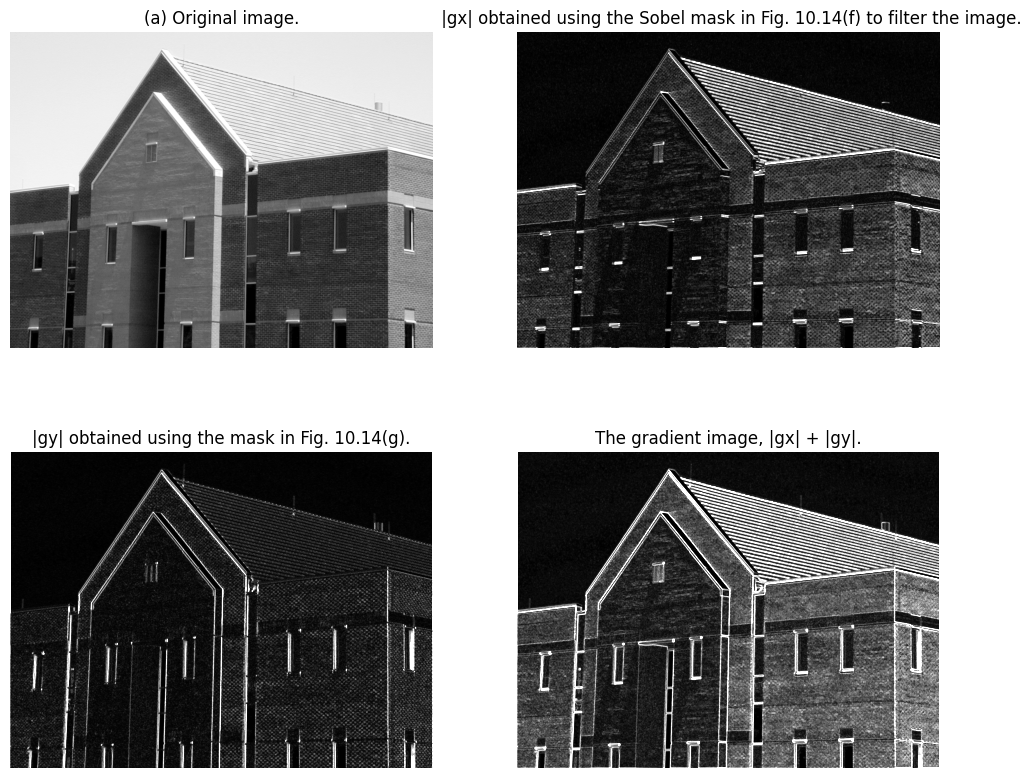

In [3]:
image = PGMImage('Fig1016(a)(building_original).pgm')

sobel_x = np.array( [[-1,-2,-1],
                     [0, 0, 0],
                     [1, 2, 1]])

sobel_y = np.array( [[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

gx = image.myImageCorrelation(sobel_x)
gy = image.myImageCorrelation(sobel_y)

g = np.abs(gx) + np.abs(gy)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("(a) Original image.")
plt.axis('off')
plt.imshow(image.pixels_2d, cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 2)
plt.title(" |gx| obtained using the Sobel mask in Fig. 10.14(f) to filter the image.")
plt.axis('off')
plt.imshow(np.abs(gx), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 3)
plt.title("|gy| obtained using the mask in Fig. 10.14(g).")
plt.axis('off')
plt.imshow(np.abs(gy), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 4)
plt.title("The gradient image, |gx| + |gy|.")
plt.axis('off')
plt.imshow(g, cmap="gray", vmin=0, vmax=255)


Yine aynı ev görüntüsü ele alınmıştır ancak burada istenmeyen çatıdaki desenleri yok etmek hedeflenmiştir. Bu amaçlar görüntü 5x5 boyutunda 1'lerden oluşan pencere ile bulanıklaştırılmıştır. Böylelikle geçişler yumuşatıldığında Sobel filtlerinin de etkisi azalmıştır. Böylelikle istenmeyen tuğla görünümünden kurtulunulmuştur.

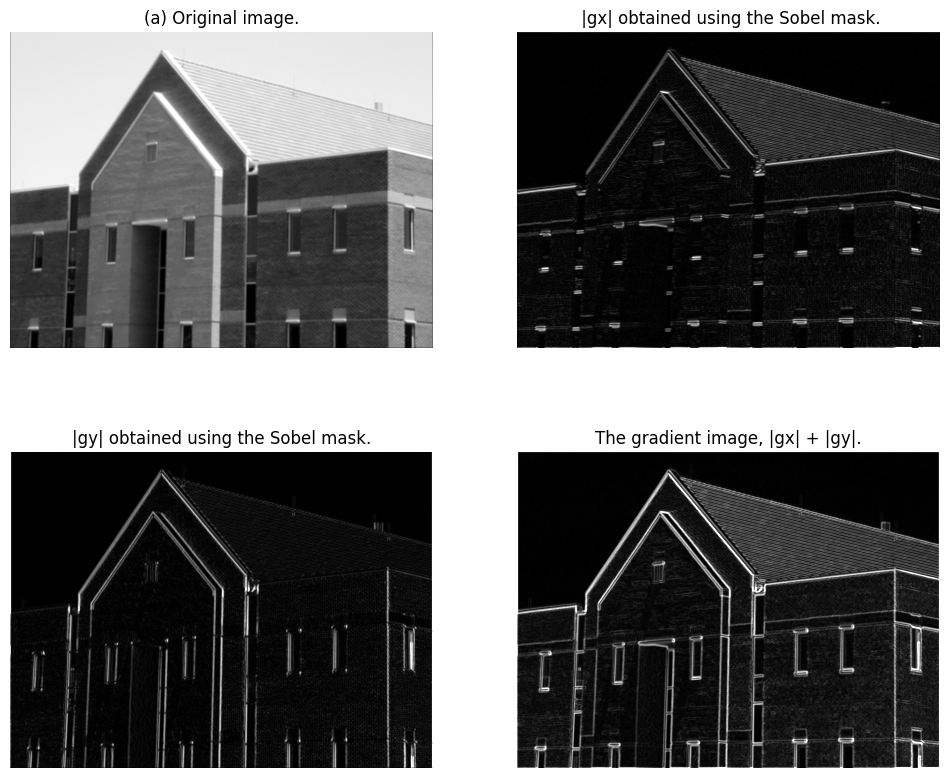

In [4]:
image = PGMImage('Fig1016(a)(building_original).pgm')
average_filter = np.ones((5, 5)) / 25

sobel_x = np.array( [[-1,-2,-1],
                     [0, 0, 0],
                     [1, 2, 1]])

sobel_y = np.array( [[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

smoothed_image = image.myImageCorrelation(average_filter)
gx = image.myImageCorrelation(sobel_x, smoothed_image)
gy = image.myImageCorrelation(sobel_y, smoothed_image)

g = np.abs(gx) + np.abs(gy)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("(a) Original image.")
plt.axis('off')
plt.imshow(smoothed_image, cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 2)
plt.title(" |gx| obtained using the Sobel mask.")
plt.axis('off')
plt.imshow(np.abs(gx), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 3)
plt.title("|gy| obtained using the Sobel mask.")
plt.axis('off')
plt.imshow(np.abs(gy), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 4)
plt.title("The gradient image, |gx| + |gy|.")
plt.axis('off')
plt.imshow(g, cmap="gray", vmin=0, vmax=255)


Bu kısımda bir parmak izi görüntüsüne yer verilmiştir ve global eşikleme yönteminin uygulanması hedeflenmiştir. Bu yöntemin bu görüntü için seçilmesinin sebebi histogramı çizildiğinde anlam kazanmaktadır. Çünkü bahsedilen yöntem her değer için belirlenen bir eşik değerine göre bütün pixellere ya 1 ya da 255 değeri atamaktır. Bu işlemin başarılı olması için gereken ise histogramda oluşan birbirinden uzak iki ayrı küme gözlemlemektir. Bu iki kümenin 0'ı kestiği nokta eşik değer olarak belirlenirse görüntü istenilen şekilde işlenebilecektir.

Bu yöntem de şu şekilde çalışmaktadır;
Başlangış eşik değeri belirlenir
bütün pixeller bu eşik değere göre ayrılır
iki grubun da ortalaması hesaplanır
grupların ortlamalarının ortalaması alınarak yeni eşik değeri belirlenir
tolerans değeri ile karşılaştırılır eğer küçükse
Bu eşik değerine göre pixel değerleri 0 ya da 255 olmak üzere ayrılır

139.96595612203788


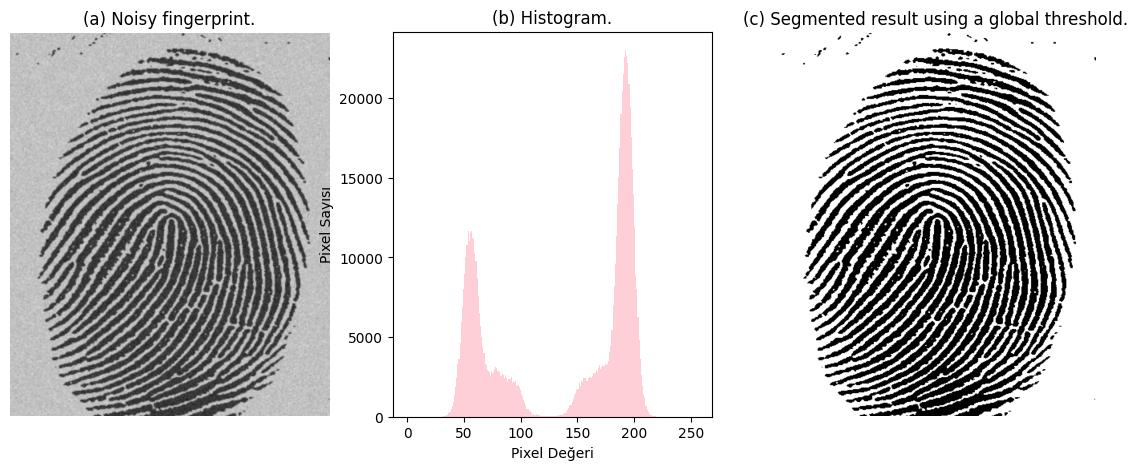

In [5]:
image = PGMImage('Fig1038(a)(noisy_fingerprint).pgm')

initial_threshold = np.mean(image.pixels_2d)
print(initial_threshold)
final_threshold, segmented_image = image.basicGlobalThresholding(125)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.title("(a) Noisy fingerprint.")
plt.axis('off')
plt.imshow(image.pixels_2d, cmap="gray", vmin=0, vmax=255)

plt.subplot(1, 3, 2)
plt.title("(b) Histogram.")
plt.hist(image.pixels_2d.ravel(), bins=256, range=[0, 256], color='pink', alpha=0.75)
plt.xlabel('Pixel Değeri')
plt.ylabel('Pixel Sayısı')

plt.subplot(1, 3, 3)
plt.title("(c) Segmented result using a global threshold.")
plt.axis('off')
plt.imshow(segmented_image, cmap="gray", vmin=0, vmax=255)

Üstüne gölge düşerek bozulmuş görüntü ise ilk olarak Otsu Yöntemi ile düzeltilmeye çalışılmıştır. Ancak başarılı bir sonuç elde edilememiştir. Bunun sebebi ise histogramı çizdirildiğinde daha net anlaşılabilmektedir. Her pixel değerine tek bir eşik değeri ile atama yapılmıştır ancak bu görüntü çok arada değerler içerdiğinden azıcık siyaha yaklaştığında pixelleri komple siyah yapıp yazının görünmemesine yol açmıştır. Bu uygulama için kullanılan Otsu fonksiyonu ChatGpt tarafından yazılmıştır.

Otsu'nun yöntemindeki başarısızlıktan sonra problemi çözmek için yerel eşikleme yöntemi kullanılmıştır. Çünkü bu görüntüdeki temel zorluk ışığın etkisinden kaynaklanan ara değerli pixellerdir bunlar global eşikleme yöntemlerinin başarısız olmasını sağlar. Moving average kullanarak eşikleme yöntemi şöyle çalışır;
Belirlenen boyutta 3x3,5x5... 1'lerden oluşan bir perncere ile görüntüye korelasyon işlemi uygulanır
Pencerenin uygulandığı pixel değerinin sonucu ile orjinal değeri karşılaştırılır. Burada korelasyonun sonucu birim matrix uygulandığından pencerenin içindeki pixellerin toplamının sayısına bölümüdür yani ortalamasıdır.
Eğer orjinal pixel değeri ortalama değerden büyükse 0 değilse 255 değeri atanır.

Böylelikle eşik değeri sürekli güncellendiğinden artıp azalan gölgenin etkisi azalmtılmış olur.

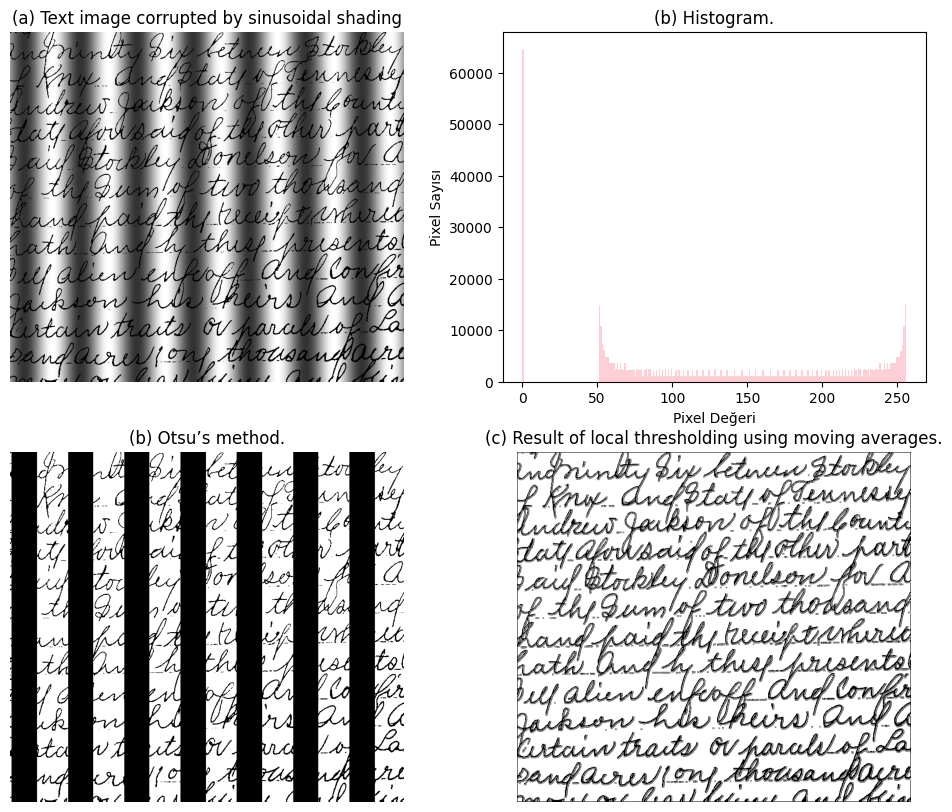

In [6]:
image = PGMImage('Fig1050(a)(sine_shaded_text_image).pgm')
average_filter = np.ones((3, 3)) / 25

optimal_threshold, segmented_image, separability = image.otsuThresholding()

segmented_image_mov_ave = image.applyKernelAndThreshold(average_filter)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("(a) Text image corrupted by sinusoidal shading")
plt.axis('off')
plt.imshow(image.pixels_2d, cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 2)
plt.title("(b) Histogram.")
plt.hist(image.pixels_2d.ravel(), bins=256, range=[0, 256], color='pink', alpha=0.75)
plt.xlabel('Pixel Değeri')
plt.ylabel('Pixel Sayısı')

plt.subplot(2, 2, 3)
plt.title("(b) Otsu’s method.")
plt.axis('off')
plt.imshow(segmented_image, cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 4)
plt.title("(c) Result of local thresholding using moving averages.")
plt.axis('off')
plt.imshow(segmented_image_mov_ave, cmap="gray", vmin=0, vmax=255)